# **Data Augmentation**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

print(f"train data shape: {x_train.shape}")
print(f"label train shape: {y_train.shape}")
print(f"test data shape: {x_test.shape}")
print(f"label test shape: {y_test.shape}")

170498071/170498071 [==============================] - 14s 0us/step
train data shape: (50000, 32, 32, 3)
label train shape: (50000, 1)
test data shape: (10000, 32, 32, 3)
label test shape: (10000, 1)


In [ ]:
num_classes = 10

y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)
print(f"label train shape: {y_train.shape}")
print(f"label test shape: {y_test.shape}")

label train shape: (50000, 10)
label test shape: (10000, 10)


## Data Augmentation Generator

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

def get_generator_aug():
    data_generator_aug = ImageDataGenerator(rescale=(1/255.0),
                                       rotation_range=35,
                                       width_shift_range=0.3,
                                       height_shift_range=0.3,
                                       fill_mode='nearest',
                                       brightness_range=(0.2,0.8),
                                       shear_range=45.0,
                                       horizontal_flip=True,
                                       vertical_flip=True,
                                       zoom_range=[0.5, 1.5])
    return data_generator_aug

In [ ]:
data_generator_aug = get_generator_aug()
data_generator_aug.fit(x_train)
train_generator_aug = data_generator_aug.flow(x_train, y_train, batch_size=10, shuffle=True)

data_generator_aug_test = get_generator_aug()
data_generator_aug_test.fit(x_test)
test_generator_aug = data_generator_aug_test.flow(x_test, y_test, batch_size=10, shuffle=True)

In [ ]:
data_generator = ImageDataGenerator(rescale=(1/255.0))
data_generator.fit(x_train)
img_generator = data_generator.flow(x_train, y_train, batch_size=10, shuffle=False)

/usr/local/lib/python3.10/dist-packages/matplotlib/text.py:1279: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


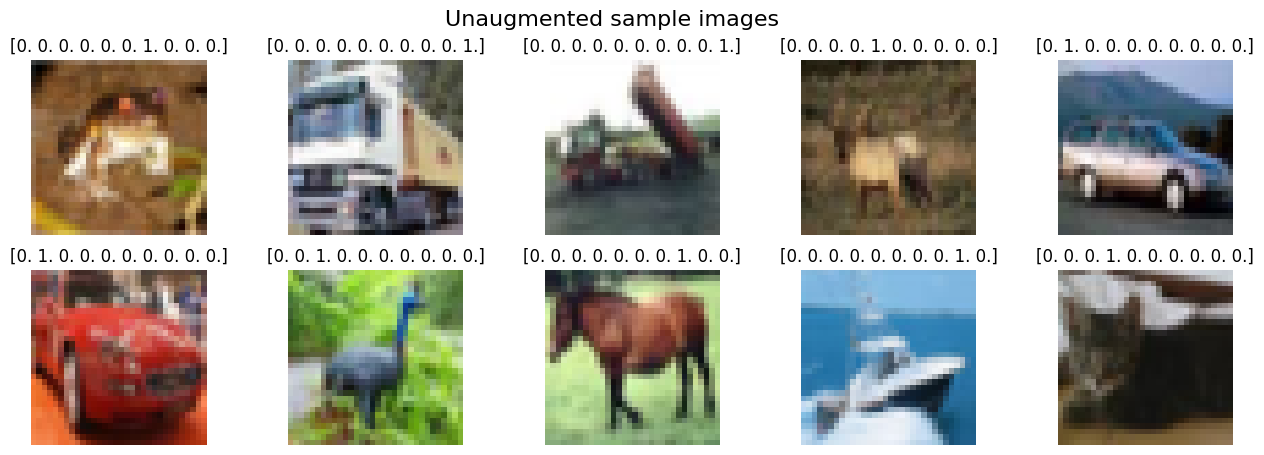

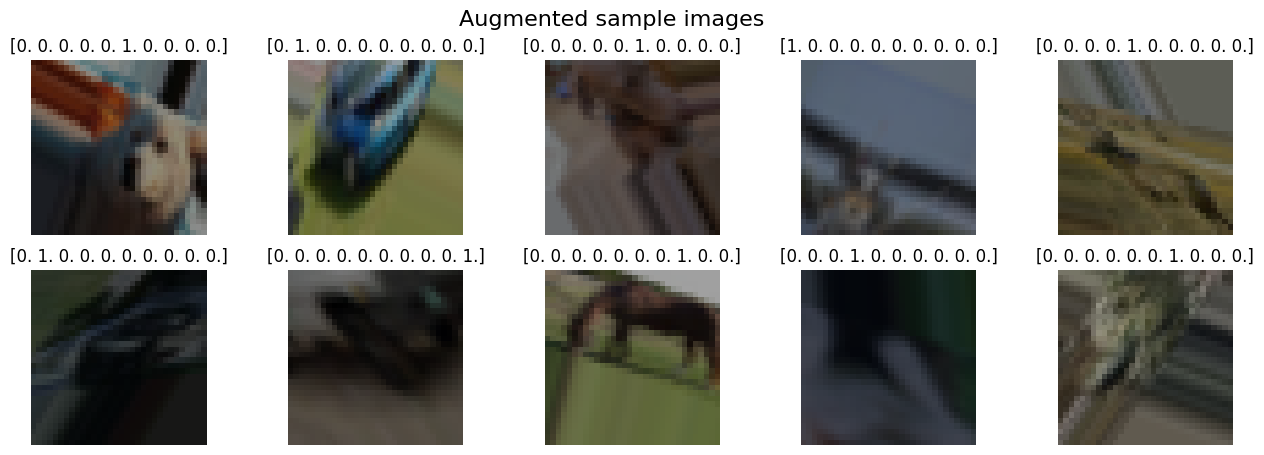

In [ ]:
img, label = next(img_generator)
img_aug, label_aug = next(train_generator_aug)

plt.figure(figsize=(16,5))
plt.suptitle("Unaugmented sample images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(img[i,...])
    plt.title(label[i])
    plt.axis('off')
plt.figure(figsize=(16,5))
plt.suptitle("Augmented sample images", fontsize=16)
for n, i in enumerate(np.arange(10)):
    ax = plt.subplot(2, 5, n+1)
    plt.imshow(img_aug[i,...])
    plt.title(label_aug[i])
    plt.axis('off')

##Model

In [ ]:
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.models import Model

def get_model(input_shape):
    input_layer = Input(input_shape)
    layer1 = Conv2D(32, 8, activation="relu", padding="SAME")(input_layer)
    layer2 = MaxPooling2D((2,2))(layer1)
    layer3 = Conv2D(32, 4, activation="relu", padding="SAME")(layer2)
    layer4 = MaxPooling2D((2,2))(layer3)
    layer5 = Flatten()(layer4)
    layer6 = Dense(16, activation="relu")(layer5)
    output_layer = Dense(10, activation="softmax")(layer6)

    model = Model(inputs=input_layer, outputs=output_layer)

    model.compile(optimizer=tf.keras.optimizers.Adam(3e-4),
                 loss='categorical_crossentropy', metrics=[tf.keras.metrics.CategoricalAccuracy()])
    return model

In [ ]:
model = get_model(input_shape = (32,32,3))
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 32, 32, 3)]       0         
                                                                 
 conv2d (Conv2D)             (None, 32, 32, 32)        6176      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 16, 16, 32)        16416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 8, 8, 32)         0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 2048)              0     

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

train_steps_per_epoch = img_generator.n // img_generator.batch_size

history = model.fit(img_generator, steps_per_epoch=train_steps_per_epoch,
                  validation_data=(x_test, y_test),
                  epochs=20,
                  callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=5)])

Epoch 1/20
5000/5000 [==============================] - 42s 6ms/step - loss: 1.6433 - categorical_accuracy: 0.4112 - val_loss: 166.8327 - val_categorical_accuracy: 0.4902
Epoch 2/20
5000/5000 [==============================] - 26s 5ms/step - loss: 1.2678 - categorical_accuracy: 0.5548 - val_loss: 159.5739 - val_categorical_accuracy: 0.5160
Epoch 3/20
5000/5000 [==============================] - 26s 5ms/step - loss: 1.1304 - categorical_accuracy: 0.6071 - val_loss: 196.9367 - val_categorical_accuracy: 0.5094
Epoch 4/20
5000/5000 [==============================] - 26s 5ms/step - loss: 1.0466 - categorical_accuracy: 0.6335 - val_loss: 158.2227 - val_categorical_accuracy: 0.5613
Epoch 5/20
5000/5000 [==============================] - 25s 5ms/step - loss: 0.9884 - categorical_accuracy: 0.6554 - val_loss: 200.2146 - val_categorical_accuracy: 0.5195
Epoch 6/20
5000/5000 [==============================] - 25s 5ms/step - loss: 0.9374 - categorical_accuracy: 0.6742 - val_loss: 162.3916 - val_cat

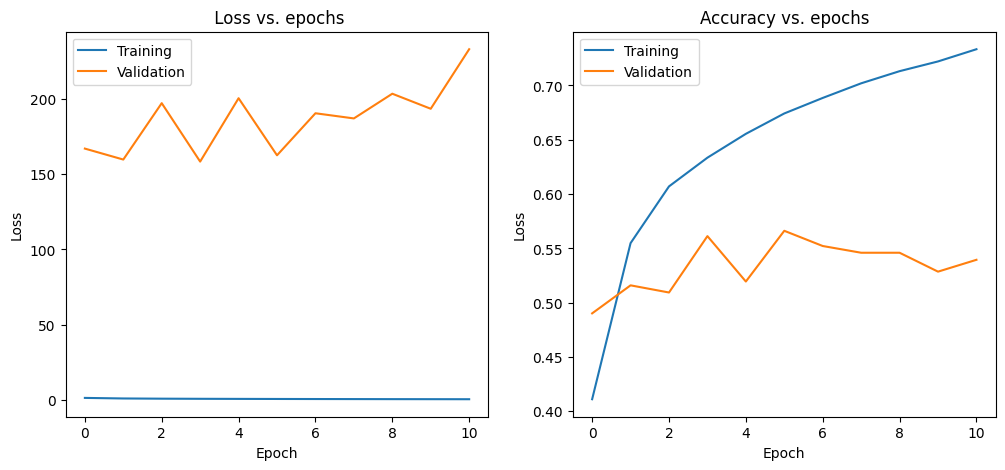

In [ ]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title(' Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

fig.add_subplot(122)

plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

plt.show()

In [ ]:
model_aug = get_model(input_shape = (32,32,3))

train_steps_per_epoch = train_generator_aug.n // train_generator_aug.batch_size

history_aug = model_aug.fit(train_generator_aug, steps_per_epoch=train_steps_per_epoch,
                  validation_data=test_generator_aug,
                  epochs=20,
                  callbacks=[EarlyStopping(monitor='val_categorical_accuracy', patience=5)])

Epoch 1/20
5000/5000 [==============================] - 76s 15ms/step - loss: 2.1244 - categorical_accuracy: 0.1912 - val_loss: 2.0619 - val_categorical_accuracy: 0.2319
Epoch 2/20
5000/5000 [==============================] - 78s 16ms/step - loss: 2.0023 - categorical_accuracy: 0.2408 - val_loss: 1.9767 - val_categorical_accuracy: 0.2527
Epoch 3/20
5000/5000 [==============================] - 72s 14ms/step - loss: 1.9497 - categorical_accuracy: 0.2683 - val_loss: 1.9086 - val_categorical_accuracy: 0.2879
Epoch 4/20
5000/5000 [==============================] - 83s 17ms/step - loss: 1.9070 - categorical_accuracy: 0.2885 - val_loss: 1.8721 - val_categorical_accuracy: 0.3084
Epoch 5/20
5000/5000 [==============================] - 74s 15ms/step - loss: 1.8741 - categorical_accuracy: 0.3030 - val_loss: 1.8467 - val_categorical_accuracy: 0.3176
Epoch 6/20
5000/5000 [==============================] - 72s 14ms/step - loss: 1.8563 - categorical_accuracy: 0.3073 - val_loss: 1.8517 - val_categoric

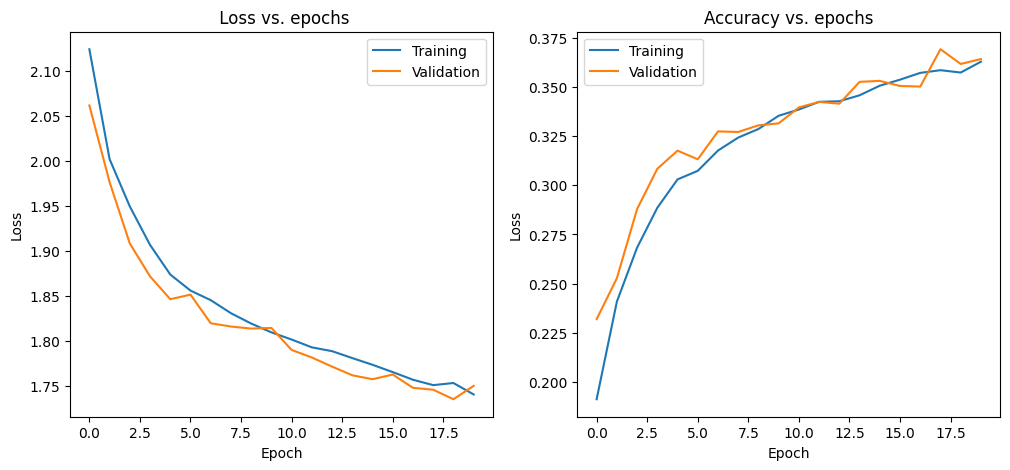

In [ ]:
fig = plt.figure(figsize=(12, 5))

fig.add_subplot(121)

plt.plot(history_aug.history['loss'])
plt.plot(history_aug.history['val_loss'])
plt.title(' Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

fig.add_subplot(122)

plt.plot(history_aug.history['categorical_accuracy'])
plt.plot(history_aug.history['val_categorical_accuracy'])
plt.title('Accuracy vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='best')

plt.show()

##Predictions

In [ ]:
predictions = model_aug.predict(test_generator_aug, steps=1)
print(np.round(predictions, 2))

1/1 [==============================] - 0s 81ms/step
[[0.19 0.03 0.18 0.12 0.09 0.12 0.06 0.03 0.16 0.03]
 [0.02 0.4  0.01 0.02 0.   0.02 0.01 0.04 0.02 0.46]
 [0.01 0.04 0.01 0.34 0.   0.5  0.   0.01 0.04 0.04]
 [0.49 0.   0.06 0.01 0.02 0.01 0.   0.01 0.38 0.01]
 [0.11 0.07 0.06 0.14 0.05 0.13 0.04 0.13 0.13 0.14]
 [0.28 0.04 0.25 0.08 0.03 0.21 0.   0.04 0.03 0.03]
 [0.05 0.28 0.02 0.06 0.01 0.08 0.   0.08 0.03 0.39]
 [0.22 0.02 0.07 0.06 0.04 0.05 0.02 0.01 0.48 0.02]
 [0.21 0.2  0.04 0.04 0.02 0.04 0.01 0.04 0.16 0.23]
 [0.22 0.01 0.23 0.05 0.15 0.1  0.02 0.18 0.02 0.02]]
